

Lukas 


09/05/2022

Big Data and Automated Content Analysis



Importing necessary packages

In [1]:
#General packages and dictionary analysis
import os
import tarfile
import bz2
import urllib.request
import re
import pickle
import requests
import pandas as pd
import numpy as np
from nltk.tokenize import TreebankWordTokenizer
import matplotlib.pyplot as plt

# Supervised text classification
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer)
from sklearn.linear_model import (
    LogisticRegression)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import (
    make_pipeline, Pipeline)
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier)
from sklearn import metrics
import joblib
import eli5
from joblib import load
from nltk.sentiment import vader

# Deep learning with Keras
from keras.layers import (Dense, Input, 
    GlobalMaxPooling1D, Conv1D, Embedding)
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.sequence import (
    pad_sequences)
from keras.preprocessing.text import Tokenizer
from gensim.models.keyedvectors import (
    KeyedVectors)

# Topic Modeling
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import (
    CoherenceModel)

import sys
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

# Tokenization
import nltk
from nltk.tokenize import (TreebankWordTokenizer, 
                           WhitespaceTokenizer)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer)
from nltk.tokenize import word_tokenize 


# For plotting word clouds
%matplotlib inline
from matplotlib import pyplot as plt
from wordcloud import WordCloud


## Preprocessing
Importing and inspecting the labeled data set

In [2]:
labeled = pd.read_csv('labeled1.csv')

In [3]:
labeled

,title,blurb,topic
0,Ora parla l’economista francese e avverte Ue: ...,"La Commissione europea, con l’Italia, sta gioc...",Economy
1,FB chiede alle banche i dati dei clienti - Int...,Facebook ha chiesto alle maggiori banche ameri...,Other
2,"Poste Italiane: partono le Domande, in tutta I...",Affinché i Portalettere in servizio possano an...,Other
3,"Aspirina pericolosa per i malatti di cuore, ri...",Il ministero della Salute Britannico ha invita...,Politics
4,"Il San Carlo a Milano, Mehta: «Spero ci siano ...",L’orchestra e il coro del Massimo in concerto ...,Politics
...,...,...,...
2576,"""Pistola in casa, 4 italiani su 10 favorevoli....",Cronaca - Approfondisci su L'Unione Sarda.it,Politics
2577,Meteo: da Lunedì 24 BREAK all'Estate: temporal...,"METEO, PREVISIONI DEL TEMPO affidabili sempre ...",Entertainment
2578,"""Lino Banfi, il dolore per la malattia della m...","""Intervistato da """"Il Messaggero"""", l'attore p...",Entertainment
2579,"La lettera di Albert Einstein su Dio, «prodott...",È stata venduta all'asta per quasi 3 milioni d...,ScienceTech


Inspecting the value counts of the topics column

In [4]:
labeled['topic'].value_counts()

Politics         1046
CrimeDisaster     486
Entertainment     484
Other             242
Sports             98
Economy            84
ScienceTech        77
Culture            64
Name: topic, dtype: int64

Checking for missing values

In [5]:
labeled.isna().sum()

title     0
blurb    11
topic     0
dtype: int64

I have decided to drop rows missing values due to the cells in which they are missing values being a crucial column used for further analysis. The slight drawback of this approach is that I am sacrificing the title columns and as such losing data. However, due to the low amount of missing values I believe this is a feasable approach moving forward.

In [6]:
#Dropping missing values
labeled= labeled.dropna(subset=['blurb'])


In [7]:
labeled.isna().sum()

title    0
blurb    0
topic    0
dtype: int64

In [8]:
labeled.shape

(2570, 3)

In [9]:
labeled.dtypes

title    object
blurb    object
topic    object
dtype: object

Creating a word cloud of the labeled data to see which words, without preprocessing are occuring the most within the topic column using 'Politics' as the value. This function was taken from https://www.youtube.com/watch?v=dtK7Xhn8XjY&t=129s&ab_channel=SolveBusinessProblemsUsingAnalytics. I do not claim this function as my own.

In [10]:
def create_wordcloud(words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

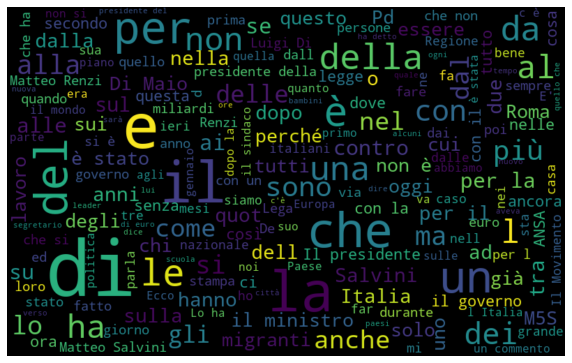

In [11]:
subset=labeled[labeled.topic=="Politics"]
text=subset.blurb.values
words =" ".join(text)
create_wordcloud(words)

After inspecting the word cloud we see that stop words are the most frequently occuring words. It thus seems plausible that stopwords, together with punctuation, are removed from the data set.

Function removing stopwords and punctuation as well as spaces that can occur at the start or end of an article. This function was taken from https://www.youtube.com/watch?v=dtK7Xhn8XjY&t=129s&ab_channel=SolveBusinessProblemsUsingAnalytics and adapted. I do not claim this function as my own.  

In [12]:
def process_text(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip() 
    text = re.sub(' +', ' ', text) 
    text = re.sub(r'[^\w\s]','',text) 
    
    
    stop_words = set(stopwords.words('italian')) 
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    text = " ".join(filtered_sentence)
    return text

Creating a new column with the parsed text without stopwords and punctuation as input. 

In [13]:
labeled['parsed_blurb'] = labeled['blurb'].apply(process_text)


<ipython-input-13-2ac3a716864e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled['parsed_blurb'] = labeled['blurb'].apply(process_text)


Creating another wordcloud of the topics column and 'Politics' as the value, to see whether the most occuring words are now words related to politics. It seems they are.

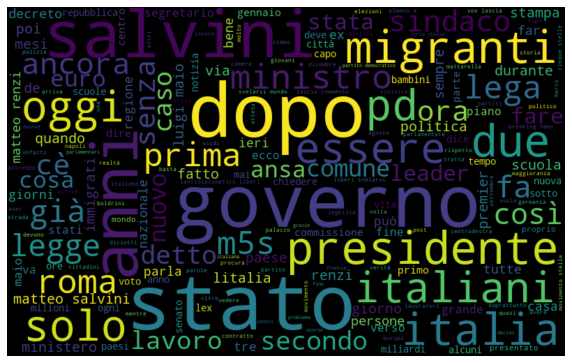

In [14]:
subset=labeled[labeled.topic=="Politics"]
text=subset.parsed_blurb.values
words =" ".join(text)
create_wordcloud(words)

Creating and applying a function that creates a binary variable for whether the article is about politics or not. A new column is then created taking the input from the 'topic' column and whether the word 'politics' is present. Articles about Politics get the value '1'. Articles that are not about politics get the value '0'.

In [15]:
#Creating binary variable for whether article is about politics or not. 
def wordlist_any_present(text, query):
    
    text = str(text).lower()
    newquery = []
    for word in query:
        newquery.append(str(word).lower())
    tokens = re.findall(r"[\w']+|[.,!?;$@#]", text)
    
    for word in newquery:
        if word in tokens:
            return 1
    return 0

Adding the new column and applying the function.

In [16]:
labeled['Politics'] = labeled['topic'].apply(wordlist_any_present, args=(['Politics'], ))


<ipython-input-16-138a10689ae4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled['Politics'] = labeled['topic'].apply(wordlist_any_present, args=(['Politics'], ))


Inspecting dataframe to see whether the applied function worked. 

In [17]:
labeled.tail()

,title,blurb,topic,parsed_blurb,Politics
2576,"""Pistola in casa, 4 italiani su 10 favorevoli....",Cronaca - Approfondisci su L'Unione Sarda.it,Politics,cronaca approfondisci lunione sardait,1
2577,Meteo: da Lunedì 24 BREAK all'Estate: temporal...,"METEO, PREVISIONI DEL TEMPO affidabili sempre ...",Entertainment,meteo previsioni tempo affidabili sempre aggio...,0
2578,"""Lino Banfi, il dolore per la malattia della m...","""Intervistato da """"Il Messaggero"""", l'attore p...",Entertainment,intervistato messaggero lattore pugliese racco...,0
2579,"La lettera di Albert Einstein su Dio, «prodott...",È stata venduta all'asta per quasi 3 milioni d...,ScienceTech,stata venduta allasta quasi 3 milioni dollari,0
2580,"Afragola, viaggio nella stazione appena inaugu...","Il diavolo si nasconde nei dettagli, anche se ...",Politics,diavolo nasconde dettagli apparenza gradevoli ...,1


Combining the title and blurb column. This is necessary in order to achieve a higher accuracy for our models. Moreover, the dataset will be split accoring to two variables, one of which has to be our binary variable whether the article is about politics or not, therefore the other column must be made up of all other relevant data to be used to train and test our models.

In [18]:
#Combining title and text column
labeled["titleblurb"] = labeled["title"] + labeled["parsed_blurb"] 

<ipython-input-18-030b5678335d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled["titleblurb"] = labeled["title"] + labeled["parsed_blurb"]


Inspecting head of final dataframe.

In [19]:
labeled.head()

,title,blurb,topic,parsed_blurb,Politics,titleblurb
0,Ora parla l’economista francese e avverte Ue: ...,"La Commissione europea, con l’Italia, sta gioc...",Economy,commissione europea litalia giocando qoutun gi...,0,Ora parla l’economista francese e avverte Ue: ...
1,FB chiede alle banche i dati dei clienti - Int...,Facebook ha chiesto alle maggiori banche ameri...,Other,facebook chiesto maggiori banche americane con...,0,FB chiede alle banche i dati dei clienti - Int...
2,"Poste Italiane: partono le Domande, in tutta I...",Affinché i Portalettere in servizio possano an...,Other,affinché portalettere servizio possano andare ...,0,"Poste Italiane: partono le Domande, in tutta I..."
3,"Aspirina pericolosa per i malatti di cuore, ri...",Il ministero della Salute Britannico ha invita...,Politics,ministero salute britannico invitato centri os...,1,"Aspirina pericolosa per i malatti di cuore, ri..."
4,"Il San Carlo a Milano, Mehta: «Spero ci siano ...",L’orchestra e il coro del Massimo in concerto ...,Politics,lorchestra coro massimo concerto capoluogo lom...,1,"Il San Carlo a Milano, Mehta: «Spero ci siano ..."


# Train/test/validation split

Splitting the data into a training and testing set on the columns 'titleblurb' being the features and 'Politics', being the labels. A test size of 0.2 and a random state of .42 will be used.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(labeled['titleblurb'], 
                                                    labeled['Politics'], 
                                                    test_size=0.2, random_state=42)

Inspecting the lengths of the training and testing sets.

In [21]:
len(X_train)

2056

In [22]:
len(X_test)

514

In [23]:
len(y_train)

2056

In [24]:
len(y_test)

514

Due to the amount of models that will be compred, a final validation set will be set aside using a testing size of 0.2. The validation set will be used to select the best approach while the testing set will be used to get the accuracy of the chosen approach. 

In [25]:
#Validation set
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2) 

In [26]:
len(X_val)

412

# Classifiers and combinations

Next, different combinations of classifiers and vectorizers are tested. They are fitted on the training data and then transformed on the test data. An accuracy score as well as a classification report has been printed to establish the best performing combinations. 
The hyperparameters of min_df and max_df are used. In most combinations the min_df is set to 5, meaning to remove words that appear in less than 5 documents. The max_df is set on .5 in most combinations, meaning to ignore words that appear in more than 50% of the documents. 

The two vectorizers used for the analysis are the CountVectorizer and the TfIdfVectorizer. These vectorizers have different methods of analyzing words in a text, therefore justifying a comparison between the two when combined with different classifiers. The different classifiers are logistic regression, Support Vector Machines (SVM), Random Forest and the Decision Tree classifier. Each of these classifiers differ in the way they organize and comprehend the data, therefore being of interest when exploring which one yields the highest accuracy. Due to the nature of our target variable, whether the article is about politics or not being binary, the logistic regression classifier seems to be a plausible classifier for comparison. Due to the dataset being made up of news articles, the Naive bayes classifier is used. This classifier is suitable for detecting likely probabilities of features within a sentence that make up whether a specific article is about politcs or not. This classifier will then calculate and output those with the highest probablities. Another SVM model that specializes in classification tasks is are SVMs. Due to the training data already being given the binary label of whether an article is about politics or not. Morevoer, they are faster and given the size of the data set might also be suited to give a higher accuracy score. Random forest and the decision tree classifier will also be used, as they are also suited for determining nominal and binary outcomes. 

In [27]:
configurations = [('NB with Count', CountVectorizer(min_df=5, max_df=.5), MultinomialNB()),
                 ('NB with TfIdf', TfidfVectorizer(min_df=5, max_df=.5), MultinomialNB()),
                 ('LogReg with Count', CountVectorizer(min_df=5, max_df=.5), LogisticRegression(solver='liblinear')),
                 ('LogReg with TfIdf', TfidfVectorizer(min_df=5, max_df=.5), LogisticRegression(solver='liblinear')),
                 ('SVM with Count - rbf kernel', CountVectorizer(min_df=5, max_df=.5), SVC(kernel='rbf')),
                 ('SVM with Count - linear kernel', CountVectorizer(min_df=5, max_df=.5), SVC(kernel='linear')),
                 ('SVM with Tfidf - rbf kernel', TfidfVectorizer(min_df=5, max_df=.5), SVC(kernel='rbf')),
                 ('SVM with Tfidf - linear kernel', TfidfVectorizer(min_df=5, max_df=.5), SVC(kernel='linear')),
                 ('RandomForest with TfIdf', TfidfVectorizer(min_df=5, max_df=1.), RandomForestClassifier()),
                 ('RandomForest with Count', CountVectorizer(min_df=5, max_df=.5), RandomForestClassifier()),
                 ('DecisionTree with TfIdf', TfidfVectorizer(min_df=10, max_df=1.), DecisionTreeClassifier()),
                 ('DecisionTree with Count', CountVectorizer(min_df=5, max_df=.5), DecisionTreeClassifier()),
                

                 ]

for description, vectorizer, classifier in configurations:
    print(description)
    X_tr = vectorizer.fit_transform(X_train)
    X_te = vectorizer.transform(X_test)
    classifier.fit(X_tr, y_train)
    y_pred = classifier.predict(X_te)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred) )
    print('\n')

NB with Count
Accuracy:  0.8015564202334631
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       297
           1       0.77      0.75      0.76       217

    accuracy                           0.80       514
   macro avg       0.80      0.79      0.80       514
weighted avg       0.80      0.80      0.80       514



NB with TfIdf
Accuracy:  0.7801556420233463
              precision    recall  f1-score   support

           0       0.76      0.90      0.83       297
           1       0.82      0.61      0.70       217

    accuracy                           0.78       514
   macro avg       0.79      0.76      0.76       514
weighted avg       0.79      0.78      0.77       514



LogReg with Count
Accuracy:  0.7879377431906615
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       297
           1       0.81      0.65      0.72       217

    accuracy                           0.7

The classification report and accuracy reports show that when the different classifiers are combined with the CountVectorizer, higher accuracy scores are achieved than with the Tfidf vectorizer. Both vectorizers in combination with the decision tree classifier give a higher precision score in predicing that an article is about politics than predicting that an article is not about politics. The best performing classifier in achieving the best accuracy scores has been the Naive Bayes classifier. In particular, when combined with the CountVectorizer, an accuracy score of .80 was achieved. The Random Forest classifier actually performed the highest on the accuracy score with a score of .81.  
As a result, these two classifiers, in combination with the CountVectorizer, will be further evaluated by tuning its hyperparameters to get an even higher accuracy, before being tested on the final validation set.

# Hyperparameter tuning

Hyperparameter tuning and finding the best performing hyperparameters using GridSearch of the best performing classifiers, MultinomialNB with CountVectorizer, MultinomialNB with TfidfVectorizer and Random Forest with CountVectorizer.

I have specified different ngram ranges for the vectorizer, from minimum and maximum of one ngram, to minimum and maximum of 2 ngrams. I have also specified the minimum and maximum document frequencies in which words can appear. As for the classifier, I have set different values for Alpha, as well as the fit_prior and class_prior hyperparameters.

In [28]:
pipeline = Pipeline(steps = [("vectorizer", CountVectorizer()), ("classifier", MultinomialNB())])
grid = {"vectorizer__ngram_range": [(1,1), (1,2), (2,2)],
        "vectorizer__max_df": [0.5, 1.0],
        "vectorizer__min_df": [0, 5],
        "classifier__alpha":[0, 0.5, 1.0],
        "classifier__fit_prior":[True, False],
        
       }
search=GridSearchCV(estimator=pipeline, n_jobs=-1,
  param_grid=grid,scoring="accuracy", cv=5)
search.fit(X_train, y_train)
print(f"Best parameters: {search.best_params_}")
pred = search.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))

Best parameters: {'classifier__alpha': 1.0, 'classifier__fit_prior': False, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 2)}
Accuracy:  0.8210116731517509
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       297
           1       0.81      0.75      0.78       217

    accuracy                           0.82       514
   macro avg       0.82      0.81      0.81       514
weighted avg       0.82      0.82      0.82       514



In [29]:
pipeline = Pipeline(steps = [("vectorizer", TfidfVectorizer()), ("classifier", MultinomialNB())])
grid = {"vectorizer__ngram_range": [(1,1), (1,2), (2,2)],
        "vectorizer__max_df": [0.5, 1.0],
        "vectorizer__min_df": [0, 1, 2, 3, 4, 5],
        "classifier__alpha":[0.5, 1.0],
        "classifier__fit_prior":[True, False],
       }
search=GridSearchCV(estimator=pipeline, n_jobs=-1,
  param_grid=grid,scoring="accuracy", cv=5)
search.fit(X_train, y_train)
print(f"Best parameters: {search.best_params_}")
pred = search.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))

Best parameters: {'classifier__alpha': 0.5, 'classifier__fit_prior': False, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 1)}
Accuracy:  0.8171206225680934
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       297
           1       0.80      0.76      0.78       217

    accuracy                           0.82       514
   macro avg       0.81      0.81      0.81       514
weighted avg       0.82      0.82      0.82       514



After hyperparameter tuning, accuracy for MultinomialNB and CountVectorizer combination has improved from .80 to .82. For the TfIdf and MultinomialNB combination accuracy has also improved from .78 to .82, yielding a higher improvement than the former. However, accuracy for the MultinomialNB and CountVectorizer remains higher, albeit only marginally. 

Performing hypermarameter tuning using GridSearch on the CountVectorizer and Random Forest combination, which initially performed quite well. However, after tuning the hyperparameters, the accuracy score dropped. 

In [30]:
pipeline = Pipeline(steps = [("vectorizer", CountVectorizer()), ("classifier", RandomForestClassifier())])
grid = {"vectorizer__max_df": [0.5, 1.0],
        "vectorizer__min_df": [0, 5],
        "classifier__n_estimators": [200, 300, 500, 800, 1200],
        "classifier__max_depth": [5, 8, 15, 25, 30],
       
       }
search=GridSearchCV(estimator=pipeline, n_jobs=-1,
  param_grid=grid,scoring="accuracy", cv=5)
search.fit(X_train, y_train)
print(f"Best parameters: {search.best_params_}")
pred = search.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))

Best parameters: {'classifier__max_depth': 30, 'classifier__n_estimators': 500, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 5}
Accuracy:  0.7762645914396887
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       297
           1       0.88      0.54      0.67       217

    accuracy                           0.78       514
   macro avg       0.81      0.74      0.75       514
weighted avg       0.80      0.78      0.76       514



Next, I will perform another Gridsearch to pinpoint the best parameters for the combination of CountVectorizer and MultinomialNB on the validation set that has been set aside in the beginning. 

In [31]:
#performing gridsearch on validation set
valpipeline = Pipeline(steps = [("vectorizer", CountVectorizer()), ("classifier", MultinomialNB())])
grid = {"vectorizer__ngram_range": [(1,1), (1,2), (2,2)],
        "vectorizer__max_df": [0.5, 1.0],
        "vectorizer__min_df": [0, 5],
        "classifier__alpha":[0, 0.5, 1.0],
        "classifier__fit_prior":[True, False],
        
       }
valsearch=GridSearchCV(estimator=valpipeline, n_jobs=-1,
  param_grid=grid,scoring="accuracy", cv=5)
search.fit(X_train2, y_train2)
print(f"Best parameters: {search.best_params_}")
pred1 = search.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, pred1))
print(metrics.classification_report(y_val, pred1))

Best parameters: {'classifier__max_depth': 30, 'classifier__n_estimators': 200, 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 5}
Accuracy:  0.7694174757281553
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       236
           1       0.89      0.52      0.66       176

    accuracy                           0.77       412
   macro avg       0.81      0.74      0.74       412
weighted avg       0.80      0.77      0.75       412



For the sake of comparison, I will also test the combination of the MultinomialNB classifier and the TfIdf Vectorizer on the validation set.

In [32]:
pipeline = Pipeline(steps = [("vectorizer", TfidfVectorizer()), ("classifier", MultinomialNB())])
grid = {"vectorizer__ngram_range": [(1,1), (1,2), (2,2)],
        "vectorizer__max_df": [0.5, 1.0],
        "vectorizer__min_df": [0, 1, 2, 3, 4, 5],
        "classifier__alpha":[0.5, 1.0],
        "classifier__fit_prior":[True, False],
       }
search=GridSearchCV(estimator=pipeline, n_jobs=-1,
  param_grid=grid,scoring="accuracy", cv=5)
search.fit(X_train2, y_train2)
print(f"Best parameters: {search.best_params_}")
pred2 = search.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, pred2))
print(metrics.classification_report(y_val, pred2))

Best parameters: {'classifier__alpha': 0.5, 'classifier__fit_prior': False, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 1)}
Accuracy:  0.837378640776699
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       236
           1       0.84      0.77      0.80       176

    accuracy                           0.84       412
   macro avg       0.84      0.83      0.83       412
weighted avg       0.84      0.84      0.84       412



Accuracy scores are higher for the TfIdf Vectorzier and MultinomialNB combination, at .82. The Tfidf vectorizer also scores higher on precision while the CountVectorizer scores higher on recall. However, due the higher accuracy achieved by the Tfidf vectorizer, I will select this combination on the unlabeled dataset

Saving the vectorizer and classifier in case of future use.

In [33]:
# Save them to disk for later use
with open("myvectorizer1.pkl",mode="wb") as f:
    pickle.dump(TfidfVectorizer, f)
with open("myclassifier1.pkl",mode="wb") as f:
    joblib.dump(MultinomialNB, f)

Getting the unlabeled dataset.

In [34]:
def get_unlabeled_data(fn='unlabeled1.csv'):
    text= []
    with open(fn, "rt", encoding='utf-8') as fi:
        next(fi)
        for row in fi:
            text.append(row.strip())
    return text


unlabeled = get_unlabeled_data()

In [35]:
unlabeled

['"Nuoto, Dall?Aglio morto in palestra","Nuoto la tragedia Nuoto, Dall’Aglio morto in palestra Guarda la versione integrale sul sito Mattia Dall’Aglio a destra, con Magnini e Detti L’atleta è stato trovato da un Vigile del Fuoco. Pare che fosse solo quando si è sentito male (forse un infarto) e cadendo abbia battuto la testa. Ora si attend..."',
 '"È ufficiale, Valentino Rossi rinnova con la Yamaha: corre fino al 2020","""Il pesarese ha firmato con la Casa di Iwata un biennale e dunque correrà in MotoGP altre due stagioni oltre a quella in partenza nel 2018. """"Essere competitivi a 40 anni è una sfida grande, ma non ho cali di motivazione, è per questo che ho firmato per due anni"""""""',
 'Real Madrid-Juve: minacce a moglie dell\'arbitro Oliver. Polizia inglese indaga,"""Gli insulti sul profilo Twitter della consorte, anche lei arbitro: """"Devi crepare tu e quel pezzo di m.... di tuo marito"""""""',
 '"""Salvini su Balotelli: """"Capitano della Nazionale? Serve umiltà""""""","""Il m

Training the classifier and vectorizer on the unlabeled data set.

In [36]:
myvec = TfidfVectorizer()
myclf = MultinomialNB()
X_tr = myvec.fit_transform(X_train)
X_unlabeled = myvec.transform(unlabeled)
myclf.fit(X_tr, y_train)

y_pred = myclf.predict(X_unlabeled)

with open("predictions.csv" , mode='w', encoding='utf-8') as fo:
    writer = csv.writer(fo)
    writer.writerows(zip(unlabeled,y_pred))

In [37]:
predictionscsv = open("predictions.csv")

In [38]:
predictionscsv

<_io.TextIOWrapper name='predictions.csv' mode='r' encoding='cp1252'>

Turning the unlabeled dataset into a Pandas dataframe.

In [39]:
predictions = pd.read_csv("predictions.csv", header=None)

In [40]:
predictions.columns = ['text', 'Politics']

Inspecting the unlabeled data after gaving added the labels. At first glance, it seems like the model has worked.

In [41]:
predictions

,text,Politics
0,"""Nuoto, Dall?Aglio morto in palestra"",""Nuoto l...",0
1,"""È ufficiale, Valentino Rossi rinnova con la Y...",0
2,Real Madrid-Juve: minacce a moglie dell'arbitr...,0
3,"""""""Salvini su Balotelli: """"""""Capitano della Na...",1
4,"""""""Juve, Tardelli e la Coppa vinta all'Heysel:...",0
...,...,...
9995,"""Belgrado, migranti in fila per il cibo sotto ...",0
9996,"""""""Hackerato il ministero degli Esteri. Anonym...",0
9997,"""Addio Stan Lee, papà dei supereroi Marvel"",""S...",0
9998,"""Ho commentato: Vitalizi: tetti, anzianità e c...",1


In [42]:
predictions['Politics'].value_counts()

0    7850
1    2150
Name: Politics, dtype: int64

In [43]:
predictions.iat[9968, 1]

1

In [44]:
predictions.iat[9968, 0]

"La fine del secolo americano - Repubblica.it,L'annuncio del ritiro dall'accordo di Parigi sul clima arriva proprio cento anni dopo l'adesione degli Usa alla Prima guerra mondiale: è il segnale che Trump ha fatto abdicare l'America dal ruolo di perno del pianeta"

After randomly searching for a as politics coded article (row 9968) and running the input through Google Translate, the text is indeed about political matter, indicating that the model has worked. Indeed, inspecting row 9996 and again running it through Google translate shows the text mentions the word 'politics' but does not seem to be specifically about political matters. Using the CountVectorzier would have likely predicted this article to be about politics, rather than just mentioning the word. Therefore, perhaps a more thorough comparison would also be apprpriate in order to investigate how well both models performed. However, a first instance indicates that everything with regard to the model using the Tfidf vectorizer went well in predicting whether an article is about politics or not.